In [1]:
# importing libraries
from os import getcwd, path
from pathlib import Path

from pandas import Series, DataFrame
import pandas as pd
import numpy as np
from typing import Set, List

from data_analysis_helper_fun import *

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [259]:
import seaborn as sns
sns.set_theme(style="ticks", 
              font_scale = 1.25,
              rc={"axes.spines.right": False, 
                  "axes.spines.top": False,
                  "lines.linewidth": 2.5,
                  "grid.color": "lightgrey"})

#sns.set(font_scale=1.5)

import matplotlib.pyplot as plt
from matplotlib_venn import venn2

plt.rcParams["figure.figsize"] = (12,10)

In [4]:
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
from plotly.subplots import make_subplots

In [5]:
# color palette
viridis = ["#472c7a", "#2c718e", "#29ae80", "#b0dd31"]
viridis_light = ["rgba(71, 44, 122, 0.5)", "rgba(44, 113, 142, 0.5)", "rgba(41, 174, 128, 0.5)", "rgba(176, 221, 49, 0.5)"]

## Loading data

In [6]:
# output directory
tables_output_dir = path.join(Path(getcwd()).parent.absolute(), "report", "tables")
figures_output_dir = path.join(Path(getcwd()).parent.absolute(), "report", "figures")

In [7]:
# relative path to data directory
data_dir = path.join(Path(getcwd()).parent.absolute(), "data")
data_set_name = 're_data_tau_alpha'
data_file_name = f'{data_set_name}.csv' #.tar.gz'

In [8]:
re_data = load_re_data(data_dir, 
                                data_file_name,
                                usecols = ["model_name",
                                           'n_sentence_pool',
                                           "ds",
                                           "init_coms",
                                           "init_coms_dia_consistent",
                                           'weight_account', 
                                           'weight_systematicity',
                                           "go_coms_consistent",
                                           "fp_coms_consistent",
                                           "fixed_point_coms_consistent",
                                           "fixed_point_dia_consistent",
                                           "n_fixed_points",
                                           "n_global_optima",
                                           "go_union_consistent",
                                           "fp_union_consistent",
                                           "error_code"
                                           ],
                               evalcols = [
                                    'go_coms_consistent',
                                    'fp_coms_consistent',
                                    "go_union_consistent",
                                    "fp_union_consistent"
                                   ],
                      filter_erroneous_runs = True)

In [9]:
print('\033[1m' + 'General information: ' + '\033[0m')
print("   Amount of rows:" , len(re_data))
print('   Number of dialectical structures:', len(re_data['ds'].unique()))
print('   Overall number of initial commitments:', len(re_data['init_coms'].unique()))
print('   Sentence-pools:' , re_data['n_sentence_pool'].unique())
print('   Models:' , re_data['model_name'].unique())
print('\n')

General information: 
   Amount of rows: 4136547
   Number of dialectical structures: 200
   Overall number of initial commitments: 80
   Sentence-pools: [6 7 8 9]
   Models: ['QuadraticGlobalRE' 'LinearGlobalRE' 'QuadraticLocalRE' 'LinearLocalRE']




In [10]:
re_data.columns

Index(['model_name', 'ds', 'n_sentence_pool', 'weight_account',
       'weight_systematicity', 'init_coms', 'init_coms_dia_consistent',
       'fixed_point_coms_consistent', 'fixed_point_dia_consistent',
       'error_code', 'n_fixed_points', 'fp_coms_consistent',
       'fp_union_consistent', 'n_global_optima', 'go_coms_consistent',
       'go_union_consistent', 'model_short_name'],
      dtype='object')

## Setup dataframes

In [260]:
""" 
If `analyse_branches` is set to `true`, all branches of RE processes are considered for the analysis. 
This may lead to the multiple counting of a unique fixed point  
if they are reached on different paths from a simulation setup.
Otherwise, the subsequent analysis comprises only unique fixed points per simulation setup.
"""
analyse_branches = False



"""Whether bootstrapping is applied to estimate mean and standard deviation"""
bootstrap = True
n_resamples = 400


# control the grouping of the dataframe during aggregation 
grouping = ['model_name',
            #'ds',
            #'init_coms',
            #'weight_account',
            #'weight_systematicity'
           ]

# Whether resulting tables and figures are exported to the corresponing output directory"""
export_results = True

In [261]:
# the analysis of global optima is not affected by status of `analyse_branches`

# restrict data to unique simulation setups to prevent multiple counting of branches 
re_data_unique_setups = re_data.drop_duplicates(["model_name",
                         "ds",
                         "n_sentence_pool",
                         'weight_account', 
                         'weight_systematicity',
                         #'weight_faithfulness', 
                         'init_coms'
                        ])

# restrict to relevant columns
go_data = re_data_unique_setups[["model_name",
                                 "ds",
                                 "n_sentence_pool",
                                 "init_coms",
                                 "weight_account", 
                                 "weight_systematicity", 
                                 "init_coms_dia_consistent", 
                                 "go_coms_consistent",
                                 "go_union_consistent"]]

# explode information about global optima, which is stored rowwise (per simulation setup) 
# in lists (e.g. in the column `go_coms_consistent`) 
exploded_go_data = go_data.set_index(["model_name",
                                      "ds",
                                      "n_sentence_pool",
                                      "init_coms",
                                      "weight_account", 
                                      "weight_systematicity", 
                                      "init_coms_dia_consistent"]).apply(pd.Series.explode).reset_index()

exploded_go_data.shape

(2845799, 9)

In [262]:
re_data_unique_setups.groupby("model_name")["ds"].size().reset_index().sort_values("ds", ascending=False)

,model_name,ds
0,LinearGlobalRE,143973
2,QuadraticGlobalRE,143964
3,QuadraticLocalRE,143079
1,LinearLocalRE,142219


In [263]:
# two models variants for global optima graphics in order to avoid (almost) redundant results
# criterion:  fewest erroneous runs
go_models = ["LinearGlobalRE", "QuadraticGlobalRE"]

In [264]:
if analyse_branches:
    
    # use all rows and restrict to relevant columns
    fp_data = re_data[["model_name",
                       "ds",
                       "n_sentence_pool",
                       "init_coms",
                       "weight_account", 
                       "weight_systematicity", 
                       "init_coms_dia_consistent", 
                       "fixed_point_coms_consistent",
                       "fixed_point_dia_consistent"]]
    
    # rename fixed point columns 
    # note: data is already exploded
    exploded_fp_data = fp_data.rename(columns={"fixed_point_coms_consistent": "fp_coms_consistent",
                                               "fixed_point_dia_consistent": "fp_union_consistent"})
    
else:
    
    # use unique setups and restrict to relevant columns
    fp_data = re_data_unique_setups[["model_name",
                                     "ds",
                                     "n_sentence_pool",
                                     "init_coms",
                                     "weight_account", 
                                     "weight_systematicity", 
                                     "init_coms_dia_consistent", 
                                     "fp_coms_consistent",
                                     "fp_union_consistent"]]
    
    # explode information about unique fixed points, which is stored rowwise (per simulation setup) 
    # in lists (e.g. in the column `go_coms_consistent`) 
    exploded_fp_data = fp_data.set_index(["model_name",
                                          "ds",
                                          "n_sentence_pool",
                                          "init_coms",
                                          "weight_account", 
                                          "weight_systematicity", 
                                          "init_coms_dia_consistent"]).apply(pd.Series.explode).reset_index()
    
exploded_fp_data.shape

(1587288, 9)

In [265]:
# quick check: If `analyse_branches` is false, the length of exploed_fp_data 
# should be equal to the number of unique fixed points in the dataframe with unique setups
re_data_unique_setups["n_fixed_points"].sum()

1587288

In [266]:
# quick check: number of unique setups. 
# Differences between model variants may arise from filtering out erroneous runs
go_data.groupby("model_name")["go_union_consistent"].size()

model_name
LinearGlobalRE       143973
LinearLocalRE        142219
QuadraticGlobalRE    143964
QuadraticLocalRE     143079
Name: go_union_consistent, dtype: int64

## Consistency I: Output
Are the outputs of RE simulations dialectically consistent?

In [186]:
#grouped_go_data = exploded_go_data.groupby(grouping)["go_coms_consistent"].agg(["sum", "size"]).reset_index()
#
#
#grouped_go_data = grouped_go_data.rename(columns={'sum': "n_go_coms_consistent",
#                                                  'size': 'n_global_optima'})
#
## relative shares
#grouped_go_data["rel_go_coms_consistent"] = grouped_go_data["n_go_coms_consistent"]/grouped_go_data["n_global_optima"]
#
#grouped_go_data

In [187]:
#grouped_fp_data = exploded_fp_data.groupby(grouping)["fp_coms_consistent"].agg(["sum", "size"]).reset_index()
#
#
#grouped_fp_data = grouped_fp_data.rename(columns={'sum': "n_fp_coms_consistent",
#                                                  'size': 'n_fixed_points'})
#
## relative shares
#grouped_fp_data["rel_fp_coms_consistent"] = grouped_fp_data["n_fp_coms_consistent"]/grouped_fp_data["n_fixed_points"]
#
#grouped_fp_data

In [188]:
## separate tables for go and fp
#
#for df, endpoint_type in zip([grouped_go_data, grouped_fp_data], ["go", "fp"]):
#    
#    # sort by model name
#    df['model_name'] = pd.Categorical(df['model_name'], ["QuadraticGlobalRE", "LinearGlobalRE", "QuadraticLocalRE", "LinearLocalRE"])
#    df.sort_values("model_name", inplace=True)
#    
#    # Changing col names for readability
#    cols_for_tables = {'model_name':'Model',
#                   'n_go_coms_consistent': 'Number of global optima with consistent commitments',
#                   'n_global_optima': 'Number of global optima',
#                   'rel_go_coms_consistent': 'Relative share of global optima with consistent commitments',
#                   'n_fp_coms_consistent': 'Number of fixed points with consistent commitments',
#                   'n_fixed_points': 'Number of fixed points',
#                   'rel_fp_coms_consistent': 'Relative share of fixed points with consistent commitments',
#                  }
#
#    display(df.rename(columns=cols_for_tables))
#    
#    
#    if export_results:
#        file_name = 'table_consistency_outputs_{}_{}.csv'.format(endpoint_type, 'branches' if analyse_branches else 'setups')
#        df.rename(columns=cols_for_tables).to_csv(path.join(tables_output_dir, file_name), index=False)
#    

In [189]:
# separate tables for go and fp

for df, endpoint_type in zip([exploded_go_data, exploded_fp_data], ["go", "fp"]):
    
    result_df = rel_share_of_property(df, 
                           "{}_coms_consistent".format(endpoint_type), 
                            col_rename = None,
                            groupby_cols=['model_name'],
                            collapse_branches=False,
                            cols_group_branches = ['model_name','ds','init_coms', 'weight_account', 'weight_systematicity'],
                            explode_cols=None,
                            bootstrap=bootstrap, 
                            n_resamples=n_resamples)
    
    result_df.reset_index(inplace=True)
    
    # sort by model name
    result_df['model_name'] = pd.Categorical(result_df['model_name'], ["QuadraticGlobalRE", 
                                                                       "LinearGlobalRE", 
                                                                       "QuadraticLocalRE", 
                                                                       "LinearLocalRE"])
    result_df.sort_values("model_name", inplace=True)
    
    # Changing col names for readability
    cols_for_tables = {'model_name':'Model',
                   'sum_go_coms_consistent': 'Number of global optima with consistent commitments',
                   'size_go_coms_consistent': 'Number of global optima',
                   'rel_go_coms_consistent': 'Relative share of global optima with consistent commitments',
                   'std_go_coms_consistent': 'Standard deviation', 
                   'sum_fp_coms_consistent': 'Number of fixed points with consistent commitments',
                   'size_fp_coms_consistent': 'Number of fixed points',
                   'rel_fp_coms_consistent': 'Relative share of fixed points with consistent commitments',
                   'std_fp_coms_consistent': 'Standard deviation',  
                  }

    display(result_df.rename(columns=cols_for_tables))
    
    
    if export_results:
        file_name = 'table_consistent_{}_{}.csv'.format(endpoint_type, 'pp' if analyse_branches else 'rp')
        result_df.rename(columns=cols_for_tables).to_csv(path.join(tables_output_dir, file_name), index=False)
    

,Model,Relative share of global optima with consistent commitments,Standard deviation,Number of global optima with consistent commitments,Number of global optima
2,QuadraticGlobalRE,0.740767,0.000521,529359,714584
0,LinearGlobalRE,0.771297,0.000528,540556,700830
3,QuadraticLocalRE,0.740822,0.000530,525490,709289
1,LinearLocalRE,0.769023,0.000504,554525,721096


,Model,Relative share of fixed points with consistent commitments,Standard deviation,Number of fixed points with consistent commitments,Number of fixed points
2,QuadraticGlobalRE,0.708426,0.000622,374476,528616
0,LinearGlobalRE,0.725553,0.000814,227097,313002
3,QuadraticLocalRE,0.734561,0.000314,1463131,1991852
1,LinearLocalRE,0.952108,0.000176,1240692,1303077


In [190]:
#import scipy.stats as spst

In [191]:
#df = pd.DataFrame(columns=["n_resamples", "std", "mean", "frac"])
#
#for frac in [round(2*j/10, 2) for j in range(1,6)]:
#    print(frac)
#    
#    col = exploded_go_data[exploded_go_data["model_name"]=="QuadraticGlobalRE"]["go_coms_consistent"].sample(frac=frac)
#
#    for i in range(1, 101):
#
#        bootstrap_res = spst.bootstrap((list(col),), np.mean, 
#                                  confidence_level=0.95,
#                                  random_state=1, 
#                                  method='percentile',
#                                  n_resamples=i*10)
#
#
#        df = df.append({"n_resamples": i*10, 
#                   "std": bootstrap_res.standard_error,
#                   "mean": np.mean(bootstrap_res.bootstrap_distribution),
#                    "frac": frac}, ignore_index=True)
#    
#    print("Resamples: ", i*10," std: ",bootstrap_res.standard_error, " mean: ", np.mean(bootstrap_res.bootstrap_distribution))

In [192]:
#df["frac_str"] = df["frac"].astype(str)
#
#
#fig=px.scatter(df, x="n_resamples", y="std", color="frac_str")
#
#fig.update_layout(title="Bootstrapping standard deviation for \"go_coms_consistent\" <br>in \"QuadraticGlobalRE\"")
#fig.update_layout(legend_title="Fraction of dataframe <br>used as sample")
#
#fig.show()
#fig.write_image("blub.png", scale=2)
#

In [193]:
#fig=px.scatter(df, x="n_resamples", y="mean", color="frac_str")
#
#fig.update_layout(title="Bootstrapping mean for \"go_coms_consistent\" <br>in \"QuadraticGlobalRE\"")
#fig.update_layout(legend_title="Fraction of dataframe <br>used as sample")
#
#fig.show()
#fig.write_image("blub2.png", scale=2)

### Sentence Pool Sizes

In [267]:
grouping = ['model_name',
            'n_sentence_pool',]

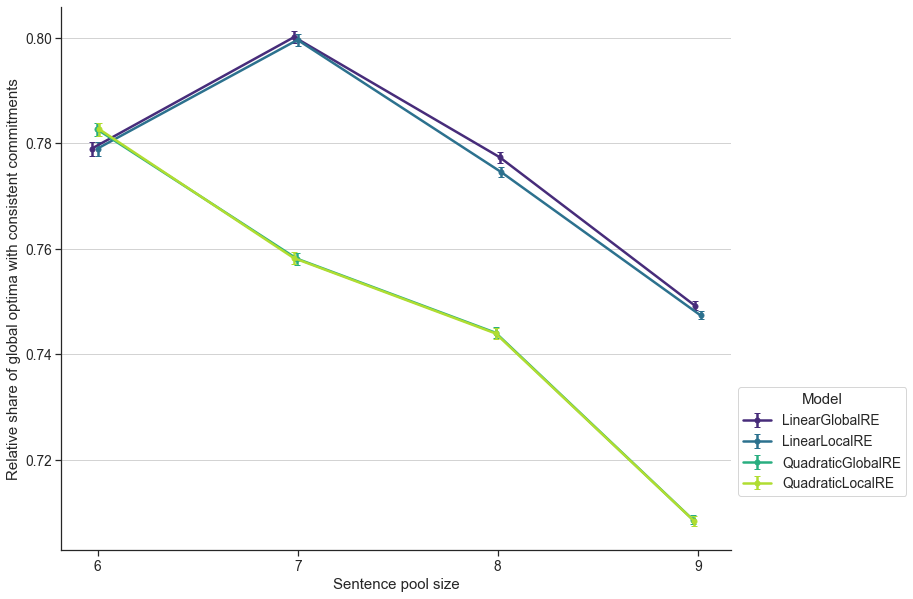

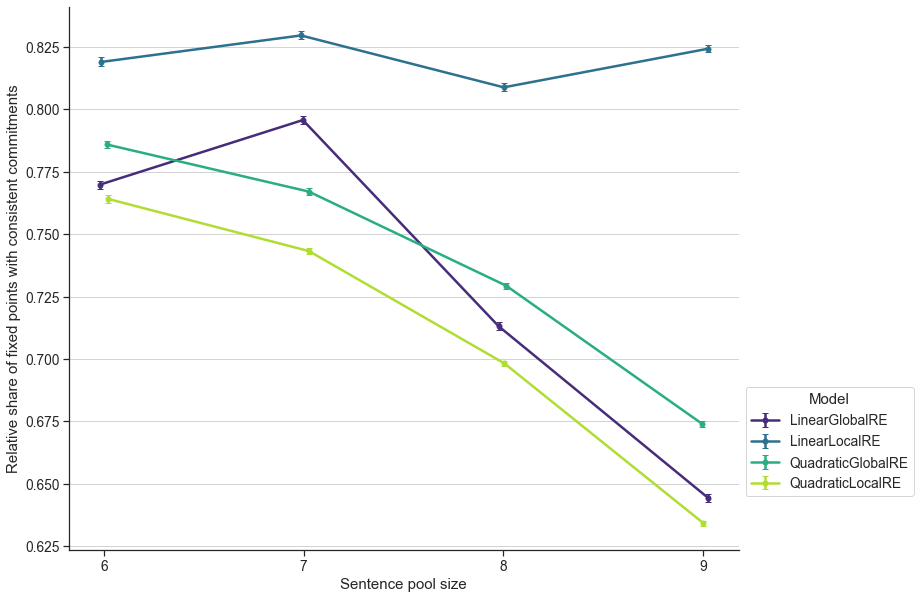

In [268]:
for df, endpoint_type in zip([exploded_go_data, exploded_fp_data], ["go", "fp"]):
    
    result_df = rel_share_of_property(df, 
                           "{}_coms_consistent".format(endpoint_type), 
                            col_rename = None,
                            groupby_cols= grouping,
                            collapse_branches=False,
                            cols_group_branches = ['model_name','ds','init_coms', 'weight_account', 'weight_systematicity'],
                            explode_cols=None,
                            bootstrap=bootstrap, 
                            n_resamples=n_resamples)
    
    endpoint = "global optima" if endpoint_type == "go" else "fixed points"
    perspective = "pp" if analyse_branches else "rp"
    
    file_name = None
    if export_results:
        file_name = f"rel_consistent_{endpoint_type}_by_sp_{perspective}"
    
    # prepare plot styling
    ax=plt.gca()
    ax.set_prop_cycle(color=viridis)
    ax.xaxis.grid(False)
    ax.yaxis.grid(True)
    
    plot_multiple_error_bars(result_df.reset_index(), 
                             var_y = f"rel_{endpoint_type}_coms_consistent", 
                             ylabel = f"Relative share of {endpoint} with consistent commitments",
                             xlabel = "Sentence pool size",
                             var_std=f"std_{endpoint_type}_coms_consistent",
                             file_name=file_name,
                             output_dir = figures_output_dir)
    
    plt.show()

### Heatmaps

In [211]:
new_grouping = ['model_name', 'weight_account','weight_systematicity']

In [212]:
#wgrouped_go_data = exploded_go_data.groupby(new_grouping)["go_coms_consistent"].agg(["sum", "size"]).reset_index()
#
#
#wgrouped_go_data = wgrouped_go_data.rename(columns={'sum': "n_go_coms_consistent",
#                                                  'size': 'n_global_optima'})
#
#wgrouped_go_data["rel_go_coms_consistent"] = wgrouped_go_data["n_go_coms_consistent"]/wgrouped_go_data["n_global_optima"]
#
## sort by model name
#wgrouped_go_data['model_name'] = pd.Categorical(wgrouped_go_data['model_name'], ["QuadraticGlobalRE", "LinearGlobalRE", "QuadraticLocalRE", "LinearLocalRE"])
#wgrouped_go_data.sort_values("model_name", inplace=True)
#
##wgrouped_go_data

In [213]:
#wgrouped_fp_data = exploded_fp_data.groupby(new_grouping)["fp_coms_consistent"].agg(["sum", "size"]).reset_index()
#
#
#wgrouped_fp_data = wgrouped_fp_data.rename(columns={'sum': "n_fp_coms_consistent",
#                                                  'size': 'n_fixed_points'})
#
#wgrouped_fp_data["rel_fp_coms_consistent"] = wgrouped_fp_data["n_fp_coms_consistent"]/wgrouped_fp_data["n_fixed_points"]
#
## sort by model name
#wgrouped_fp_data['model_name'] = pd.Categorical(wgrouped_fp_data['model_name'], ["QuadraticGlobalRE", "LinearGlobalRE", "QuadraticLocalRE", "LinearLocalRE"])
#wgrouped_fp_data.sort_values("model_name", inplace=True)
#
#wgrouped_fp_data

In [210]:
sns.set(font_scale=1.0)

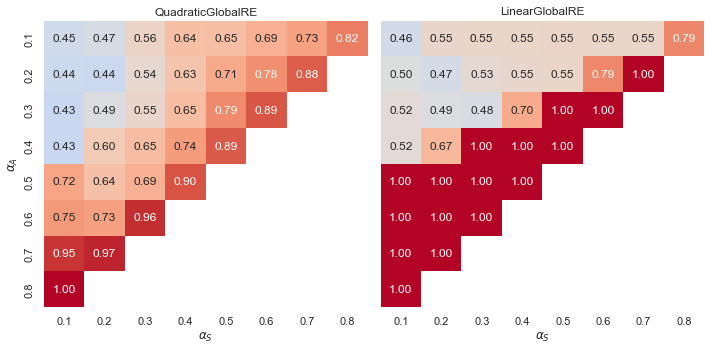

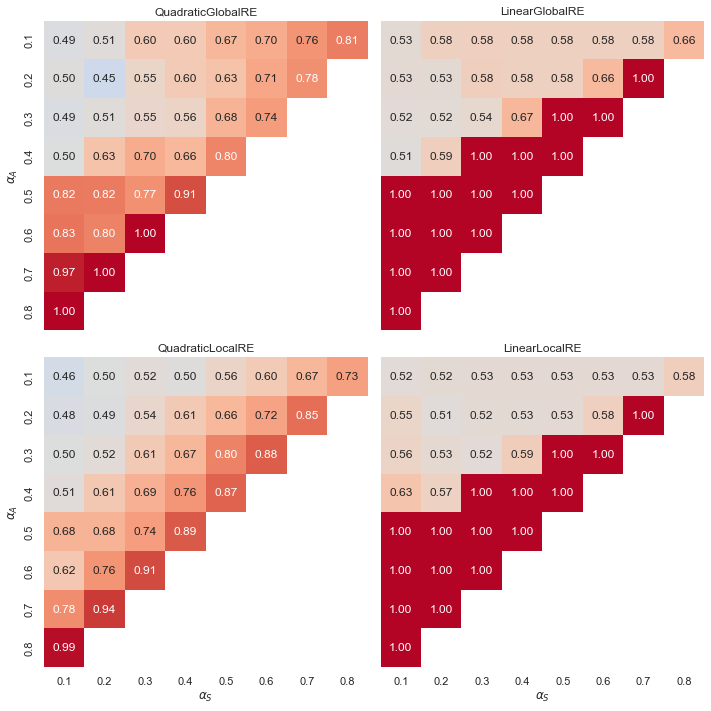

In [214]:
for df, endpoint_type in zip([exploded_go_data, exploded_fp_data], ["go", "fp"]):

    endpoint = "global opima" if endpoint_type == "go" else "fixed points"
    
    if (analyse_branches) & (endpoint_type=="fp"):
        endpoint += " (all branches)"
    
    # restrict global optima dataframe to two variants
    if endpoint_type=="go":
        df = df[df["model_name"].isin(go_models)]
    
    heat_maps_by_weights(re_data = df, 
                     values = "{}_coms_consistent".format(endpoint_type), 
                     #title = 'Relative share of consistent commitments among {}'.format(endpoint),
                     annot_std = False,
                     annot_fmt="{:2.2f}\n", 
                     annot_std_fmt = r'$\pm${:2.2f}',
                     vmin=0, vmax=1,
                     bootstrap=bootstrap,
                     n_resamples=n_resamples)
    
    
    perspective = "pp" if analyse_branches else "rp"
        
    if export_results:
        plt.savefig(path.join(figures_output_dir, 'hm_consistent_coms_{}_{}.png'.format(endpoint_type, perspective)), bbox_inches='tight')
        plt.savefig(path.join(figures_output_dir, 'hm_consistent_coms_{}_{}.pdf'.format(endpoint_type, perspective)), bbox_inches='tight')
        
    plt.show()

## Consistency II:  Input-Output
Does the consistency status change between corresponding inputs and outputs of RE simulations?

### Labelling cases

In [269]:
# conversion to type bool
exploded_go_data['init_coms_dia_consistent'] = exploded_go_data['init_coms_dia_consistent'].astype('bool')
exploded_go_data['go_coms_consistent'] = exploded_go_data['go_coms_consistent'].astype('bool')

In [270]:
# global optima
exploded_go_data['go_inconsistency_eliminating_case'] = (~exploded_go_data['init_coms_dia_consistent']) & exploded_go_data['go_coms_consistent']
exploded_go_data['go_consistency_preserving_case'] = exploded_go_data['init_coms_dia_consistent'] & exploded_go_data['go_coms_consistent']
exploded_go_data['go_inconsistency_preserving_case'] = (~exploded_go_data['init_coms_dia_consistent']) & (~exploded_go_data['go_coms_consistent'])
exploded_go_data['go_consistency_eliminating_case'] = (exploded_go_data['init_coms_dia_consistent']) & (~exploded_go_data['go_coms_consistent'])

In [271]:
display(exploded_go_data.head(6)[[#'global_optima',
                                  'init_coms_dia_consistent',
                                  'go_coms_consistent', 
                                  'go_inconsistency_eliminating_case',
                                  'go_consistency_preserving_case',
                                  'go_inconsistency_preserving_case',
                                  'go_consistency_eliminating_case'
                                 ]])

,init_coms_dia_consistent,go_coms_consistent,go_inconsistency_eliminating_case,go_consistency_preserving_case,go_inconsistency_preserving_case,go_consistency_eliminating_case
0,True,False,False,False,False,True
1,True,True,False,True,False,False
2,True,True,False,True,False,False
3,True,True,False,True,False,False
4,True,True,False,True,False,False
5,True,True,False,True,False,False


In [272]:
# conversion to type bool
exploded_fp_data['init_coms_dia_consistent'] = exploded_fp_data['init_coms_dia_consistent'].astype('bool')
exploded_fp_data['fp_coms_consistent'] = exploded_fp_data['fp_coms_consistent'].astype('bool')

In [273]:
# fixed points
exploded_fp_data['fp_inconsistency_eliminating_case'] = ~(exploded_fp_data['init_coms_dia_consistent']) & exploded_fp_data['fp_coms_consistent']
exploded_fp_data['fp_consistency_preserving_case'] = exploded_fp_data['init_coms_dia_consistent'] & exploded_fp_data['fp_coms_consistent']
exploded_fp_data['fp_inconsistency_preserving_case'] = ~(exploded_fp_data['init_coms_dia_consistent']) & ~(exploded_fp_data['fp_coms_consistent'])
exploded_fp_data['fp_consistency_eliminating_case'] = exploded_fp_data['init_coms_dia_consistent'] & ~(exploded_fp_data['fp_coms_consistent'])

In [95]:
# count cases in a group
#go_result_df = exploded_go_data[['model_name',
#                                 "ds",
#                                 "init_coms",
#                                 'weight_account', 
#                                 'weight_systematicity', 
#                                 'go_coms_consistent', 
#                                 'go_inconsistency_eliminating_case',
#                                 'go_consistency_preserving_case',
#                                 'go_inconsistency_preserving_case',
#                                 'go_consistency_eliminating_case']].groupby(grouping).agg('sum').reset_index()
#
## count total number of global optima in a group
#go_result_df['n_global_optima'] = go_result_df.apply(lambda x: sum(x[col] for col in ['go_inconsistency_eliminating_case',
#                                 'go_consistency_preserving_case',
#                                 'go_inconsistency_preserving_case',
#                                 'go_consistency_eliminating_case']) , axis=1)
#
##go_result_df.reset_index(inplace=True)

In [96]:
#go_result_df.shape

In [97]:
#go_result_df["n_global_optima"].sum()

In [98]:
#re_data_unique_setups["n_global_optima"].sum()

In [99]:
## count cases in a group
#fp_result_df = exploded_fp_data[['model_name',
#                                 'ds',
#                                 'init_coms',
#                                 'weight_account', 
#                                 'weight_systematicity', 
#                                 'fp_coms_consistent', 
#                                 'fp_inconsistency_eliminating_case',
#                                 'fp_consistency_preserving_case',
#                                 'fp_inconsistency_preserving_case',
#                                 'fp_consistency_eliminating_case']].groupby(grouping).agg('sum').reset_index()
#
## count total number of fixe points in a group
#fp_result_df['n_fixed_points'] = fp_result_df.apply(lambda x: sum(x[col] for col in ['fp_inconsistency_eliminating_case',
#                                 'fp_consistency_preserving_case',
#                                 'fp_inconsistency_preserving_case',
#                                 'fp_consistency_eliminating_case']) , axis=1)
#
##fp_result_df.reset_index(inplace=True)

In [100]:
# quick check: number of fixed points
#fp_result_df["n_fixed_points"].sum()

### Tables

In [101]:
## relative share of consistency cases
#
#for df, endpoint_type in zip([fp_result_df, go_result_df], ['fp', 'go']):
#    for case_name in ["inconsistency_eliminating", 
#                      "consistency_preserving", 
#                      "inconsistency_preserving", 
#                      "consistency_eliminating"]:
#        
#        endpoint_name = "n_global_optima" if endpoint_type == "go" else "n_fixed_points"
#    
#        relative_share_col_name = 'rel_' + endpoint_type + '_' + case_name + '_case' 
#        
#        df[relative_share_col_name] = df[endpoint_type + '_' + case_name + '_case']/df[endpoint_name]

In [102]:
# group by model name and calculate average (depending on grouping, this may be superfluous)

#fp_overall_results = fp_result_df.groupby(['model_name',
#                     #'ds',
#                     #'init_coms',
#                     #'weight_account',
#                     #'weight_systematicity'
#                     ])[["rel_fp_inconsistency_eliminating_case",
#                         "rel_fp_consistency_preserving_case",
#                         "rel_fp_inconsistency_preserving_case",
#                         "rel_fp_consistency_eliminating_case"]].mean().reset_index()
#
#
#go_overall_results = go_result_df.groupby(['model_name',
#                     #'ds',
#                     #'init_coms',
#                     #'weight_account',
#                     #'weight_systematicity'
#                     ])[["rel_go_inconsistency_eliminating_case",
#                         "rel_go_consistency_preserving_case",
#                         "rel_go_inconsistency_preserving_case",
#                         "rel_go_consistency_eliminating_case"]].mean().reset_index()

In [103]:
# separate tables for go and fp

#for df, endpoint_type in zip([go_overall_results, fp_overall_results], ["go", "fp"]):
#    
#    
#    # sort by model name
#    df['model_name'] = pd.Categorical(df['model_name'], ["QuadraticGlobalRE", "LinearGlobalRE", "QuadraticLocalRE", "LinearLocalRE"])
#    df.sort_values("model_name", inplace=True)
#    
#    # Changing col names for readability
#    cols_for_tables = {'model_name':'Model',
#                   "rel_go_inconsistency_eliminating_case": "Relative share of inconsistency eliminating cases among global optima",
#                   "rel_go_consistency_preserving_case": "Relative share of consistency preserving cases among global optima",
#                   "rel_go_inconsistency_preserving_case": "Relative share of inconsistency preserving cases among global optima",
#                   "rel_go_consistency_eliminating_case": "Relative share of consistency eliminating cases among global optima",
#                   "rel_fp_inconsistency_eliminating_case": "Relative share of inconsistency eliminating cases among fixed points",
#                   "rel_fp_consistency_preserving_case": "Relative share of consistency preserving cases among fixed points",
#                   "rel_fp_inconsistency_preserving_case": "Relative share of inconsistency preserving cases among fixed points",
#                   "rel_fp_consistency_eliminating_case": "Relative share of consistency eliminating cases among fixed points",
#                  }
#
#    display(df.rename(columns=cols_for_tables))
#    
#    
#    # Exporting relevant cols
#    if export_results:
#        file_name = 'table_consistency_cases_{}_{}.csv'.format(endpoint_type, 'branches' if analyse_branches else 'setups')
#        df.rename(columns=cols_for_tables).to_csv(path.join(tables_output_dir, file_name), index=False)
#    

In [104]:
# separate tables for go and fp



for df, endpoint_type in zip([exploded_go_data, exploded_fp_data], ["go", "fp"]):
    
    result_df = None
    
    for case_name in ["consistency_preserving",
                      "consistency_eliminating",
                      "inconsistency_preserving",
                      "inconsistency_eliminating", 
                      ]:
        
        
        if case_name in ["consistency_preserving", "consistency_eliminating"]:
            # consistent init coms
            rdf = df[df["init_coms_dia_consistent"]]
        else:
            rdf = df[~df["init_coms_dia_consistent"]]
        
        new_result_df = rel_share_of_property(rdf,
                            endpoint_type + "_" + case_name + "_case", 
                            col_rename = None,
                            groupby_cols=['model_name'],
                            collapse_branches=False,
                            cols_group_branches = ['model_name','ds','init_coms', 'weight_account', 'weight_systematicity'],
                            explode_cols=None,
                            bootstrap=bootstrap, 
                            n_resamples=n_resamples)
        
        new_result_df.reset_index(inplace=True)
        
        
        if result_df is None:
            result_df = new_result_df
        else:
            result_df = result_df.join(new_result_df.set_index("model_name"), on="model_name")
                
    # for later use
    if endpoint_type == "go":
        go_result_df = result_df
    else:
        fp_result_df = result_df
    
    # sort by model name
    result_df['model_name'] = pd.Categorical(result_df['model_name'], ["QuadraticGlobalRE", 
                                                                       "LinearGlobalRE", 
                                                                       "QuadraticLocalRE", 
                                                                       "LinearLocalRE"])
    result_df.sort_values("model_name", inplace=True)
    
    # Changing col names for readability
    cols_for_tables = {'model_name':'Model',
                   "size_go_inconsistency_eliminating_case": "Number of global optima from inconsistent initial commitments",
                   "size_fp_consistency_eliminating_case": "Number of fixed points from consistent initial commitments",
                   "size_go_consistency_eliminating_case": "Number of global optima from consistent initial commitments",
                   "size_fp_inconsistency_eliminating_case": "Number of fixed points from inconsistent initial commitments",
                   "rel_go_inconsistency_eliminating_case": "Relative share of inconsistency eliminating cases",
                   "rel_go_consistency_preserving_case": "Relative share of consistency preserving cases",
                   "rel_go_inconsistency_preserving_case": "Relative share of inconsistency preserving cases",
                   "rel_go_consistency_eliminating_case": "Relative share of consistency eliminating cases",
                   "rel_fp_inconsistency_eliminating_case": "Relative share of inconsistency eliminating cases",
                   "rel_fp_consistency_preserving_case": "Relative share of consistency preserving cases",
                   "rel_fp_inconsistency_preserving_case": "Relative share of inconsistency preserving cases",
                   "rel_fp_consistency_eliminating_case": "Relative share of consistency eliminating cases",
                   "std_go_inconsistency_eliminating_case": "Standard deviation IE cases",
                   "std_fp_inconsistency_eliminating_case": "Standard deviation IE cases",
                   "std_go_inconsistency_preserving_case": "Standard deviation IP cases",
                   "std_fp_inconsistency_preserving_case": "Standard deviation IP cases",
                   "std_go_consistency_preserving_case": "Standard deviation CP cases",
                   "std_fp_consistency_preserving_case": "Standard deviation CP cases",
                   "std_go_consistency_eliminating_case": "Standard deviation CE cases",
                   "std_fp_consistency_eliminating_case": "Standard deviation CE cases",
                  }
    renamed_result_df = result_df.rename(columns=cols_for_tables)
    
    # restrict to most relevant columns
    retain_columns = [col for col in renamed_result_df.columns if (("size" not in col) and ("sum" not in col))]
    
    renamed_result_df = renamed_result_df[retain_columns]
    
    # reorder columns (number of endpoints should go to front)
    ordered_cols = []

    ordered_cols.append(renamed_result_df.columns[0])
    ordered_cols.append(renamed_result_df.columns[3])
    ordered_cols.append(renamed_result_df.columns[1])
    ordered_cols.append(renamed_result_df.columns[2])
    for col in renamed_result_df.columns[4:]:
        ordered_cols.append(col)

    renamed_result_df = renamed_result_df[ordered_cols]

    display(renamed_result_df)
    
    
    # Exporting relevant cols
    if export_results:
        file_name = 'table_consistency_cases_{}_{}.csv'.format(endpoint_type, 'pp' if analyse_branches else 'rp')
        renamed_result_df.to_csv(path.join(tables_output_dir, file_name), index=False)
    

,Model,Relative share of consistency eliminating cases,Relative share of consistency preserving cases,Standard deviation CP cases,Standard deviation CE cases,Number of global optima from consistent initial commitments,Relative share of inconsistency preserving cases,Standard deviation IP cases,Relative share of inconsistency eliminating cases,Standard deviation IE cases,Number of global optima from inconsistent initial commitments
2,QuadraticGlobalRE,0.053200,0.946800,0.000362,0.000362,386131,0.501364,0.000846,0.498636,0.000846,328453
0,LinearGlobalRE,0.023503,0.976497,0.000226,0.000226,366296,0.453375,0.000888,0.546625,0.000888,334534
3,QuadraticLocalRE,0.052501,0.947499,0.000372,0.000372,384850,0.504173,0.000942,0.495827,0.000942,324439
1,LinearLocalRE,0.023341,0.976659,0.000246,0.000246,372362,0.452729,0.000840,0.547271,0.000840,348734


,Model,Relative share of consistency eliminating cases,Relative share of consistency preserving cases,Standard deviation CP cases,Standard deviation CE cases,Number of fixed points from consistent initial commitments,Relative share of inconsistency preserving cases,Standard deviation IP cases,Relative share of inconsistency eliminating cases,Standard deviation IE cases,Number of fixed points from inconsistent initial commitments
2,QuadraticGlobalRE,0.040807,0.959193,0.000398,0.000398,246823,0.542521,0.001107,0.457479,0.001107,211324
0,LinearGlobalRE,0.016188,0.983812,0.000302,0.000302,168946,0.577352,0.001346,0.422648,0.001346,143837
3,QuadraticLocalRE,0.044704,0.955296,0.000400,0.000400,278450,0.551531,0.000868,0.448469,0.000868,309786
1,LinearLocalRE,0.014079,0.985921,0.000356,0.000356,119476,0.361423,0.001496,0.638577,0.001496,108646


### Plots

#### Barplots

#### Overall barplots across configuration of weights

In [105]:
def barplot(data, endpoint_type, init_coms_consistent):
    
    # restrict global optima dataframe to two variants
    if endpoint_type=="go":
        rdata = data[data["model_name"].isin(go_models)]
    else:
        rdata=data
    
    if init_coms_consistent:
        y_cols = ["rel_{}_consistency_preserving_case".format(endpoint_type),
                  "rel_{}_consistency_eliminating_case".format(endpoint_type)]
    else:
        y_cols = ["rel_{}_inconsistency_eliminating_case".format(endpoint_type),
                  "rel_{}_inconsistency_preserving_case".format(endpoint_type)]    
    
    fig3 = px.bar(rdata.round(3), 
                  x="model_name", 
                  y=y_cols,
                  barmode="stack", 
                  text_auto=True)

    fig3.update_yaxes(range=[0.0, 1.0])
    fig3.update_traces(name="Consistency preserving (CP)", 
                       marker_color=viridis[1], 
                       selector=dict(name='rel_{}_consistency_preserving_case'.format(endpoint_type)))
    
    fig3.update_traces(name="Inconsistency eliminating (IE)", 
                       marker_color=viridis[3],
                       selector=dict(name='rel_{}_inconsistency_eliminating_case'.format(endpoint_type)))
    
    fig3.update_traces(name="Inconsistency preserving (IP)",
                       marker_color=viridis[2],
                       selector=dict(name='rel_{}_inconsistency_preserving_case'.format(endpoint_type)))
    
    fig3.update_traces(name="Consistency eliminating (CE)",
                       marker_color=viridis[0], 
                       selector=dict(name="rel_{}_consistency_eliminating_case".format(endpoint_type)))

    fig3.update_layout(template="plotly_white",
                       #paper_bgcolor="#e9e8e6",
                       #plot_bgcolor="#e9e8e6",
                       font={"color": "black", "size":12},
                       width=860 if endpoint_type=="fp" else 580,
                       margin={"t":80}
                      )

    fig3.update_xaxes(title="Model variant", showticklabels=True, showgrid=False, linecolor= 'DarkGrey')
    fig3.update_yaxes(title="Relative share", ticks="outside", tickcolor="DarkGrey", showgrid=False, linecolor='DarkGrey', zeroline=True, zerolinecolor="DarkGrey",
                      zerolinewidth=1)
    fig3.update_layout(legend_title_text="")
    fig3.update_layout(legend={'traceorder':'reversed', 
                              "orientation":"v", "x":1.0, "y":1.025, "xanchor":"left"})
    #fig3.update_layout(title_text="Relative share of consistency cases among {}".format("global optima" if endpoint_type=="go" else "fixed points"))
    fig3.update_traces(opacity=0.8)
    fig3.show()



    if export_results:
        file_name = 'consistency_cases_{}_{}_{}.png'.format(endpoint_type,
                                                                 "ic_cons" if init_coms_consistent else "ic_incons",
                                                                 'pp' if analyse_branches else 'rp')
        fig3.write_image(path.join(figures_output_dir, file_name), scale=2)
        
        file_name = 'consistency_cases_{}_{}_{}.pdf'.format(endpoint_type,
                                                                 "ic_cons" if init_coms_consistent else "ic_incons",
                                                                 'pp' if analyse_branches else 'rp')
        fig3.write_image(path.join(figures_output_dir, file_name), scale=2)

In [106]:
barplot(go_result_df, "go", True)
barplot(fp_result_df, "fp", True)
barplot(go_result_df, "go", False)
barplot(fp_result_df, "fp", False)

#### Sentence Pool Sizes

In [274]:
grouping = ['model_name', "n_sentence_pool"]

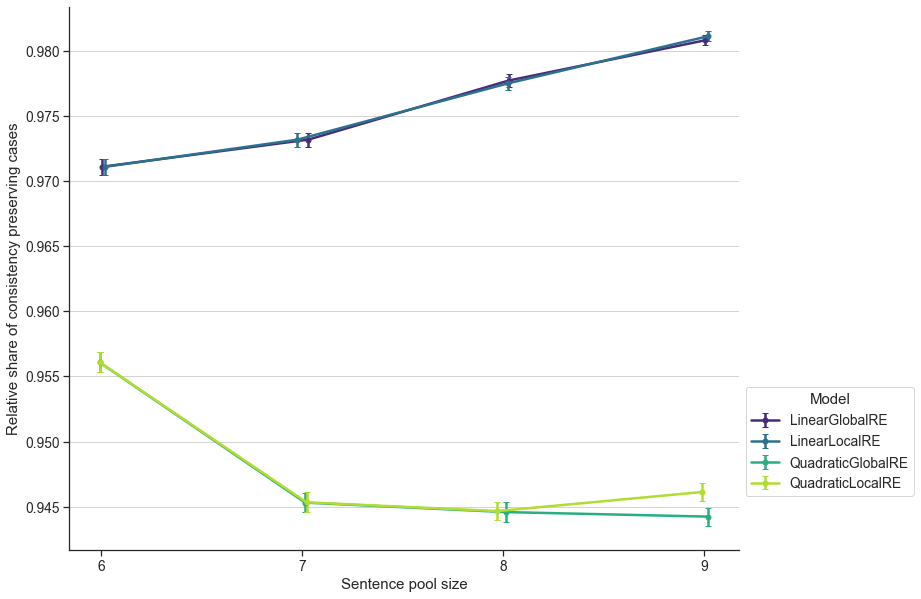

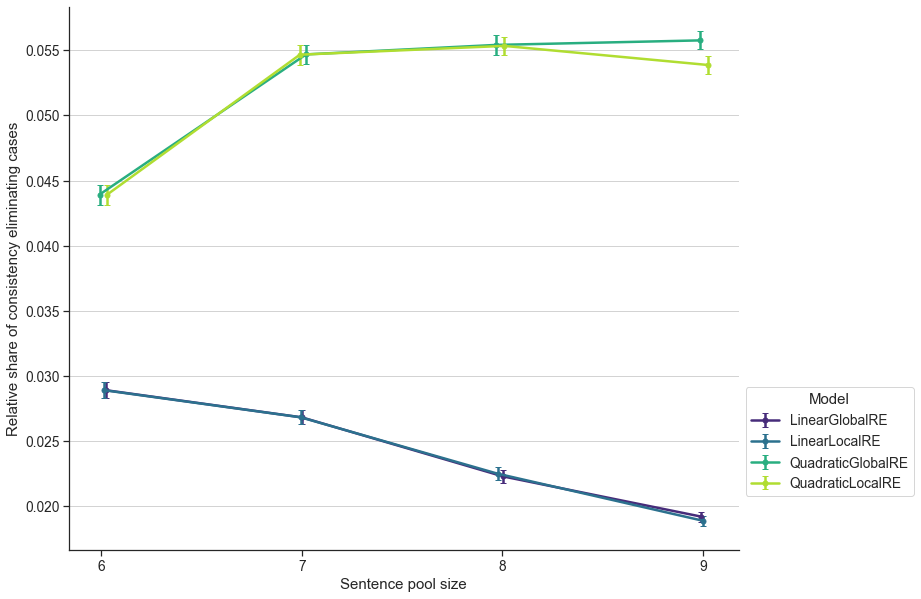

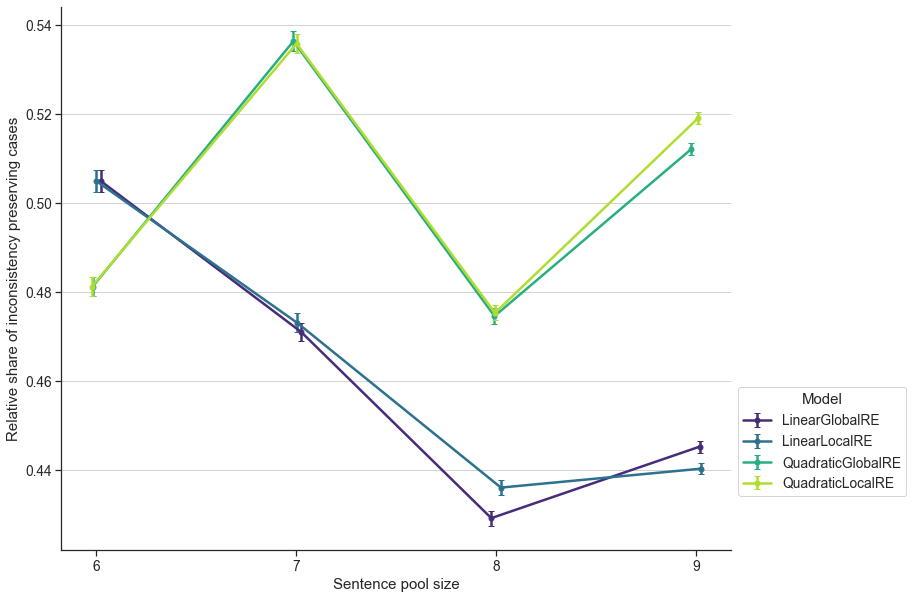

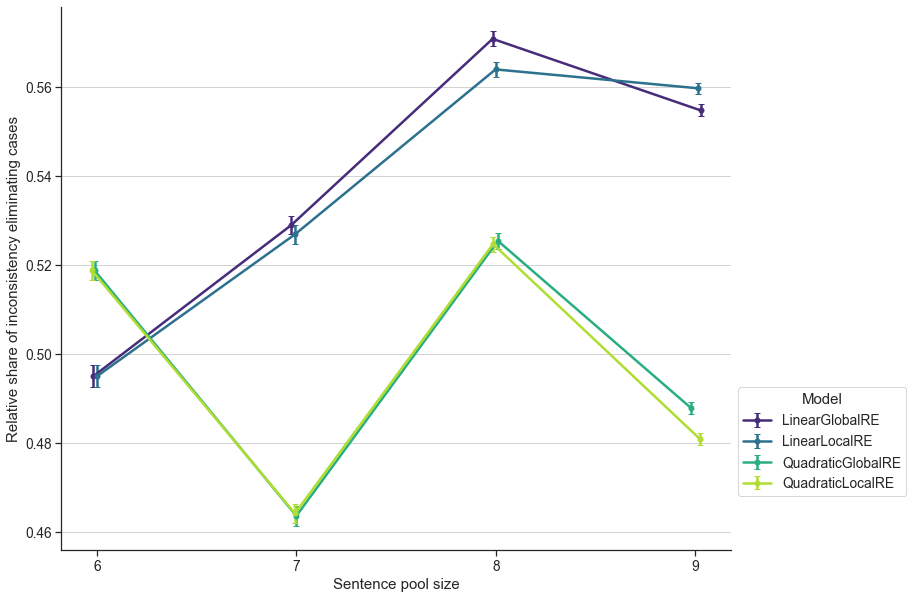

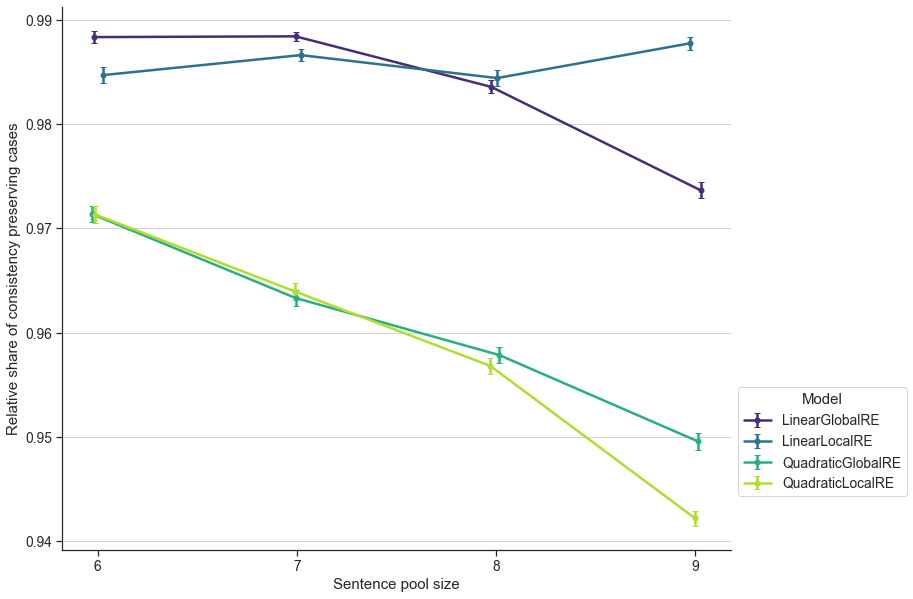

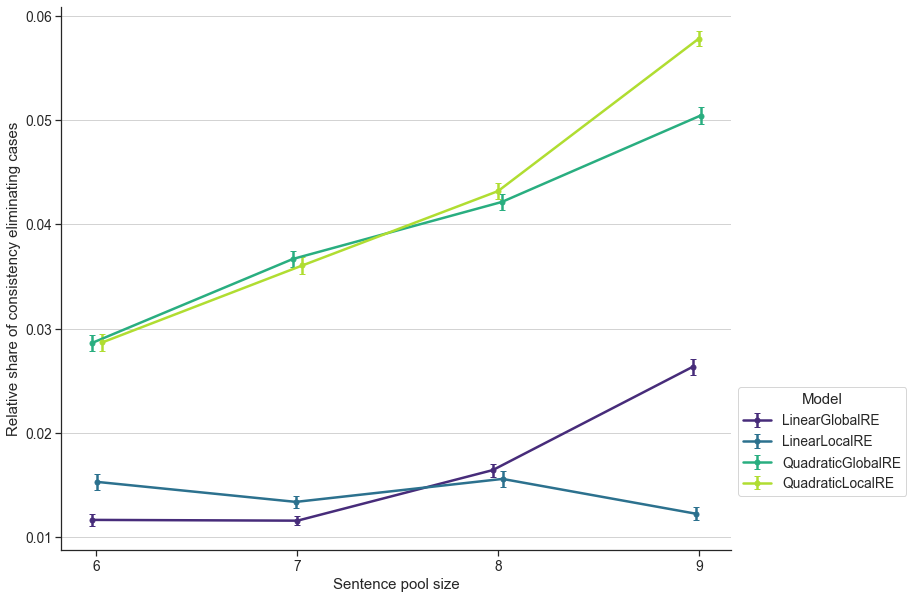

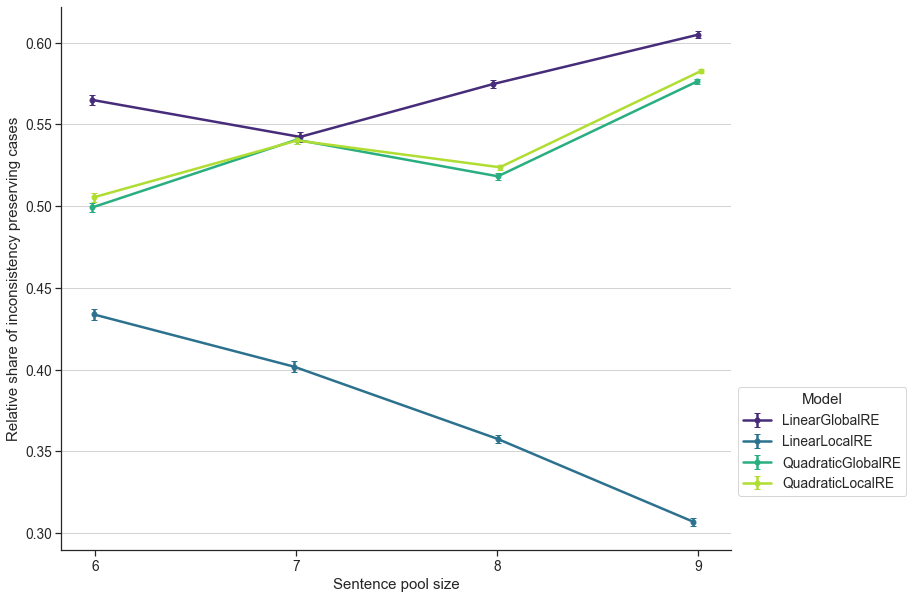

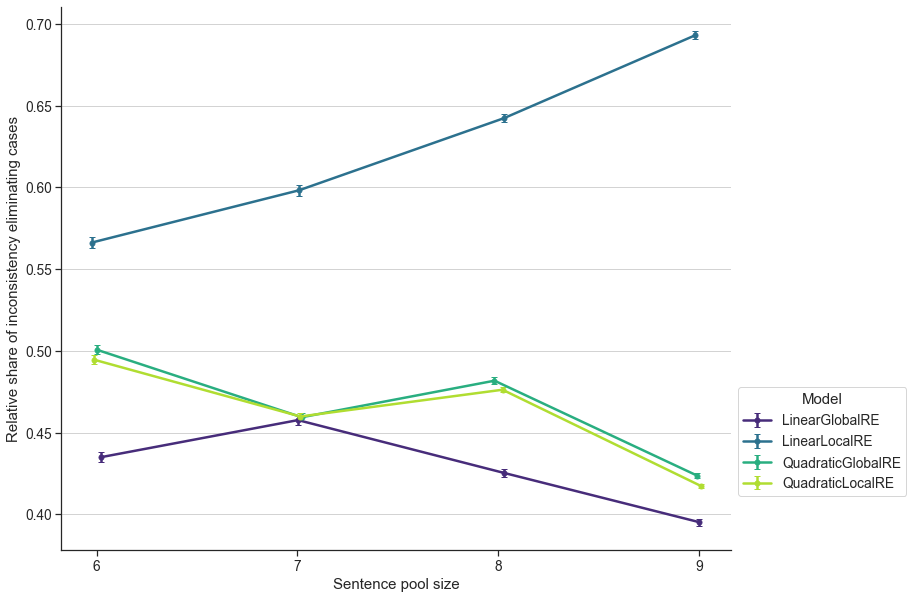

In [275]:
for df, endpoint_type in zip([exploded_go_data, exploded_fp_data], ["go", "fp"]):
    
    for case_name in ["consistency_preserving",
                      "consistency_eliminating",
                      "inconsistency_preserving",
                      "inconsistency_eliminating", 
                      ]:
        
        if case_name in ["consistency_preserving", "consistency_eliminating"]:
            # consistent init coms
            rdf = df[df["init_coms_dia_consistent"]]
        else:
            rdf = df[~df["init_coms_dia_consistent"]]
        
        result_df = rel_share_of_property(rdf,
                            endpoint_type + "_" + case_name + "_case", 
                            col_rename = None,
                            groupby_cols=grouping,
                            collapse_branches=False,
                            cols_group_branches = ['model_name','ds','init_coms', 'weight_account', 'weight_systematicity'],
                            explode_cols=None,
                            bootstrap=bootstrap, 
                            n_resamples=n_resamples)
        
    
        endpoint = "global optima" if endpoint_type == "go" else "fixed points"
        perspective = "pp" if analyse_branches else "rp"

        file_name = None
        if export_results:
            file_name = f"rel_{case_name}_case_{endpoint_type}_by_sp_{perspective}"
            
        # prepare plot styling
        ax=plt.gca()
        ax.set_prop_cycle(color=viridis)
        ax.xaxis.grid(False)
        ax.yaxis.grid(True)


        plot_multiple_error_bars(result_df.reset_index(), 
                                 var_y = f"rel_{endpoint_type}_{case_name}_case", 
                                 ylabel = f"Relative share of {case_name.replace('_', ' ')} cases",
                                 xlabel = "Sentence pool size",
                                 var_std= f"std_{endpoint_type}_{case_name}_case",
                                 file_name=file_name,
                                 output_dir = figures_output_dir)
    
    
    
        plt.show()

#### Heatmaps

In [109]:
# new_grouping = ['model_name', 'weight_account','weight_systematicity']

In [110]:
# fixed_points

# count cases in a group
#fp_df = exploded_fp_data[['model_name',
#                                 'ds',
#                                 'init_coms',
#                                 'weight_account', 
#                                 'weight_systematicity', 
#                                 'fp_coms_consistent', 
#                                 'fp_inconsistency_eliminating_case',
#                                 'fp_consistency_preserving_case',
#                                 'fp_inconsistency_preserving_case',
#                                 'fp_consistency_eliminating_case']].groupby(new_grouping).agg('sum').reset_index()
#
## count total number of fixed points in a group
#fp_df['n_fixed_points'] = fp_df.apply(lambda x: sum(x[col] for col in ['fp_inconsistency_eliminating_case',
#                                 'fp_consistency_preserving_case',
#                                 'fp_inconsistency_preserving_case',
#                                 'fp_consistency_eliminating_case']) , axis=1)
#
#
## sort by model name
#fp_df['model_name'] = pd.Categorical(fp_df['model_name'], ["QuadraticGlobalRE", "LinearGlobalRE", "QuadraticLocalRE", "LinearLocalRE"])
#fp_df.sort_values("model_name", inplace=True)

In [111]:
#fp_df['n_fixed_points'].sum()

In [112]:
# global optima

# count cases in a group
#go_df = exploded_go_data[['model_name',
#                                 "ds",
#                                 "init_coms",
#                                 'weight_account', 
#                                 'weight_systematicity', 
#                                 'go_coms_consistent', 
#                                 'go_inconsistency_eliminating_case',
#                                 'go_consistency_preserving_case',
#                                 'go_inconsistency_preserving_case',
#                                 'go_consistency_eliminating_case']].groupby(new_grouping).agg('sum').reset_index()
#
## count total number of global optima in a group
#go_df['n_global_optima'] = go_df.apply(lambda x: sum(x[col] for col in ['go_inconsistency_eliminating_case',
#                                 'go_consistency_preserving_case',
#                                 'go_inconsistency_preserving_case',
#                                 'go_consistency_eliminating_case']) , axis=1)
#
##go_result_df.reset_index(inplace=True)
#
## sort by model name
#go_df['model_name'] = pd.Categorical(go_df['model_name'], ["QuadraticGlobalRE", "LinearGlobalRE", "QuadraticLocalRE", "LinearLocalRE"])
#go_df.sort_values("model_name", inplace=True)

In [113]:
# relative share of consistency cases

#for df, endpoint_type in zip([fp_df, go_df], ['fp', 'go']):
#    for case_name in ["inconsistency_eliminating", 
#                      "consistency_preserving", 
#                      "inconsistency_preserving", 
#                      "consistency_eliminating"]:
#        
#        endpoint_name = "n_global_optima" if endpoint_type == "go" else "n_fixed_points"
#    
#        relative_share_col_name = 'rel_' + endpoint_type + '_' + case_name + '_case' 
#        
#        df[relative_share_col_name] = df[endpoint_type + '_' + case_name + '_case']/df[endpoint_name]

In [114]:
def case_heatmaps_by_weights(data, endpoint_type, case_name, analyse_branches):
    
    
    # restrict global optima dataframe to two variants
    if endpoint_type=="go":
        rdata = data[data["model_name"].isin(go_models)]
    else:
        rdata=data
        
    if case_name in ["consistency_preserving", "consistency_eliminating"]:
        # consistent init coms
        rdata = rdata[rdata["init_coms_dia_consistent"]]
    else:
        # inconsistent init coms
        rdata = rdata[~rdata["init_coms_dia_consistent"]]
        
    
    
    #metric = "Relative"
    #branches=""
    
    #if analyse_branches:
    #    metric = "Relative"
    #    branches = " (all branches)" if endpoint_type=="fp" else ""
         
    
    values_name = endpoint_type + '_' + case_name + '_case' 
        
    
    display_case_name = " ".join(case_name.split("_"))
    #display_endpoint_type = "global optima" if endpoint_type == "go" else "fixed points"
    
    heat_maps_by_weights(re_data = rdata, 
                     values = values_name, 
                     #title = '{} share of {} cases for {}{}'.format(metric, display_case_name, display_endpoint_type, branches), 
                     annot_std = False,
                     annot_fmt="{:2.2f}\n", 
                     annot_std_fmt = r'$\pm${:2.2f}',
                     vmin=0, vmax=1,
                     bootstrap = bootstrap,
                     n_resamples = n_resamples)

In [ ]:
sns.set(font_scale=1.0)

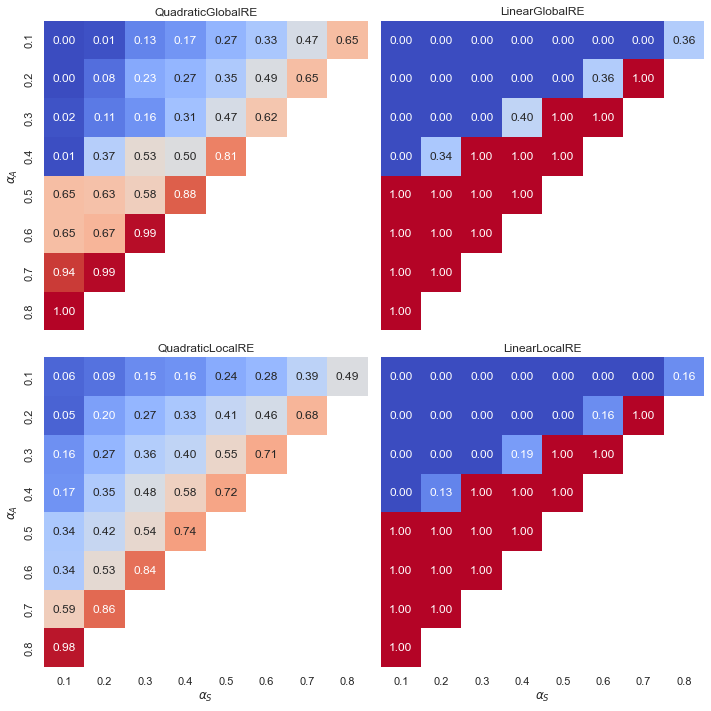

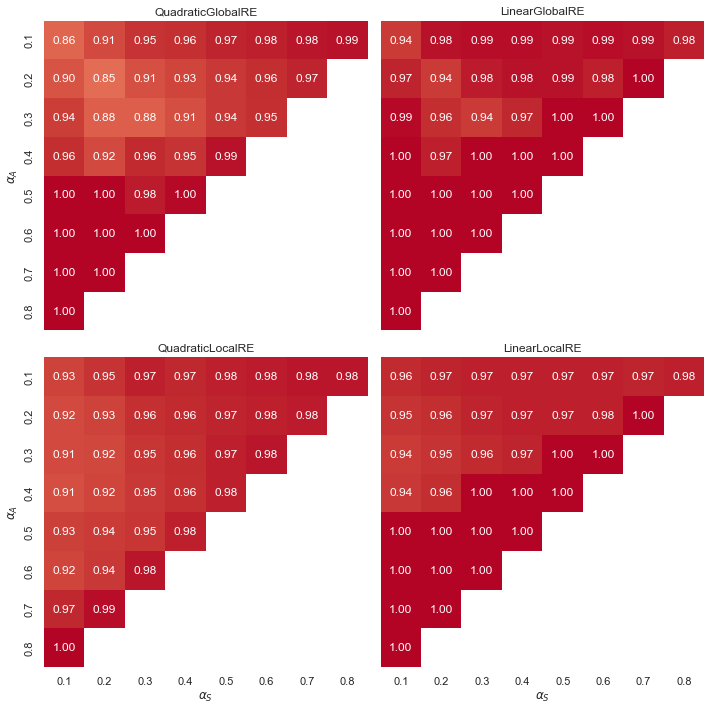

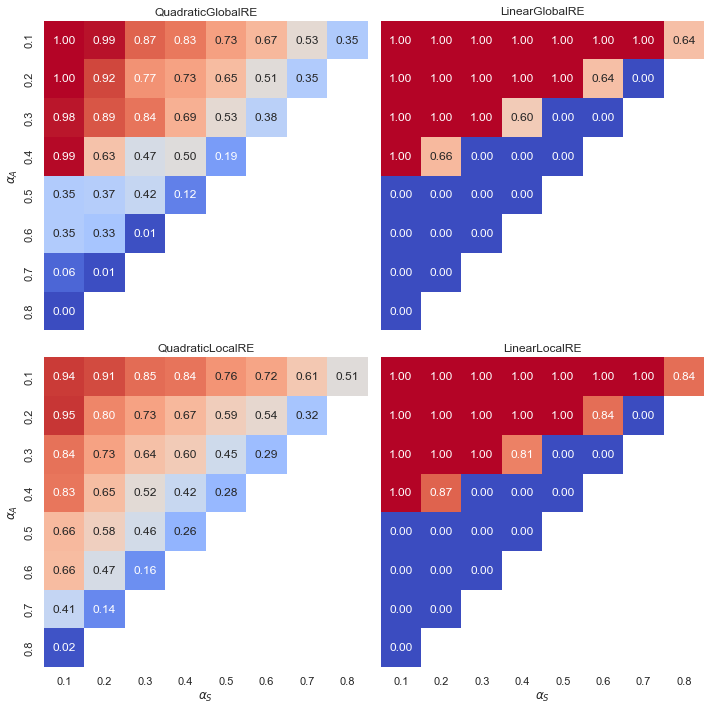

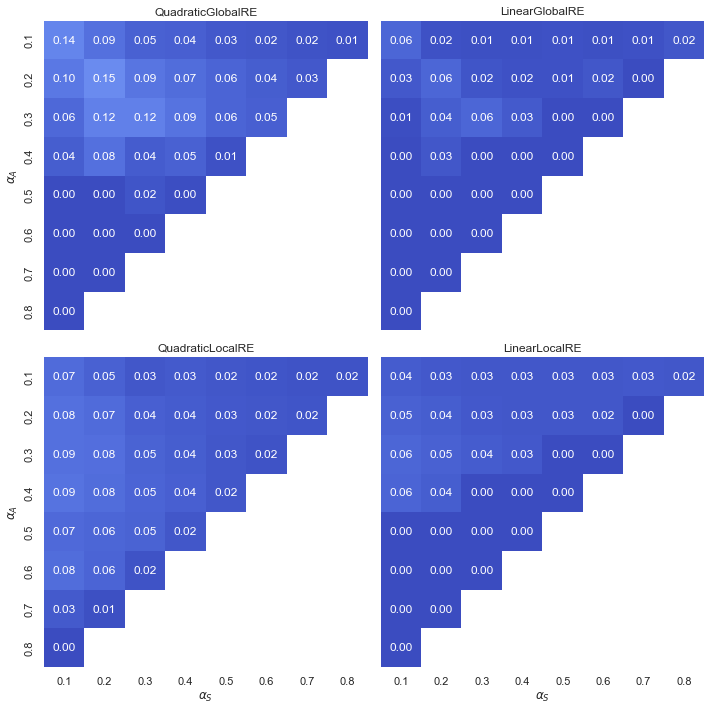

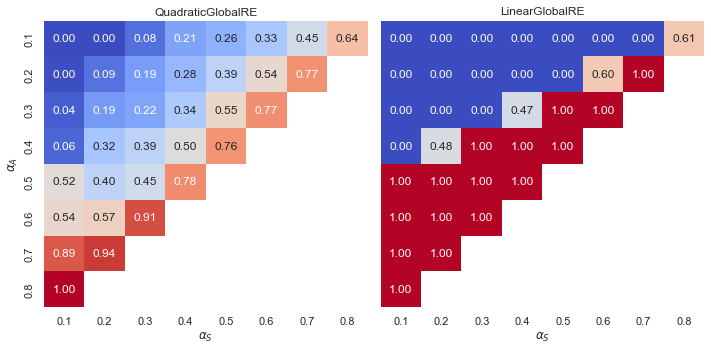

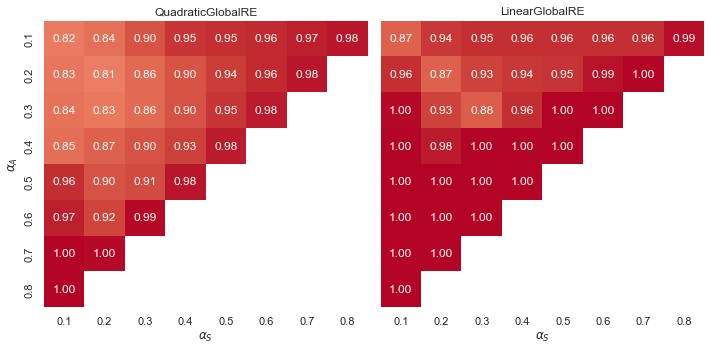

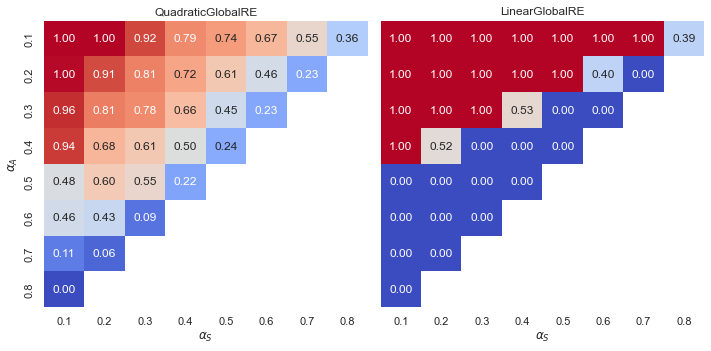

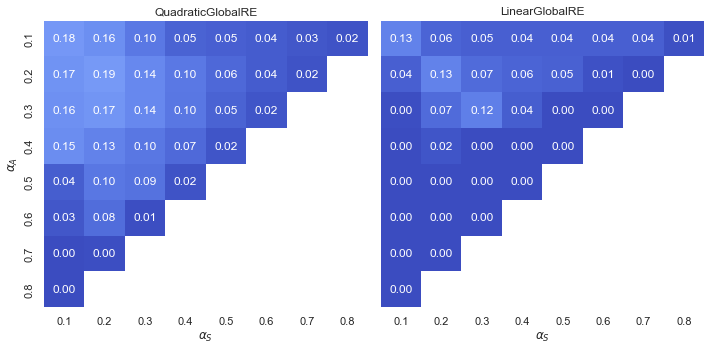

In [115]:
for df, endpoint_type in zip([exploded_fp_data, exploded_go_data], ['fp', 'go']):
    for case_name in ["inconsistency_eliminating", 
                      "consistency_preserving", 
                      "inconsistency_preserving", 
                      "consistency_eliminating"]:
        
        case_heatmaps_by_weights(df, endpoint_type, case_name, analyse_branches)
        
        branches = "pp" if analyse_branches else "rp"
        
        if export_results:
            plt.savefig(path.join(figures_output_dir, 'hm_{}_{}_cases_{}.png'.format(endpoint_type, case_name, branches)), bbox_inches='tight')
            plt.savefig(path.join(figures_output_dir, 'hm_{}_{}_cases_{}.pdf'.format(endpoint_type, case_name, branches)), bbox_inches='tight')

## Consistency III: Union
Is the union of output theory and output commitments dialectically consistent?

### Dialectical consistency of positions in global optima and fixed point

Here, we only count those in-/consistencies, which result from combining dialectically consistent commitments with their theories. In other words, we are interested in those inconsistencies in positions which cannot be explained by commitments being inconsistent on their own (which we already assessed above).

Relevant data fields:

+ The field `go_union_consistent`: A list of bools (List[bool]) indicating whether the unions of a commitment-theory-tuple of the global_optima are dialectically consistent. I.e. whether the global optima are RE states.The order of the list represents the order in global_optima.
+ The fied `fp_union_consistent`: A list of bools (List[bool]) indicating whether the unions of a commitment-theory-tuple of the fixed_points are dialectically consistent.The order of the list represents the order in fixed_points.

In [116]:


## The col `go_union_consistent` contains values indicating whether the union of coms and theories is 
## consistent. Here, we restrict the list to those values where the coms are consistent on their own.
#
## for gos
#re_data['go_union_consistent_restr'] = re_data.apply(lambda x: [x['go_union_consistent'][i] 
#                                                                 for i in range(x['n_global_optima']) 
#                                                                 if x['go_coms_consistent'][i]], axis=1)
#re_data['go_union_consistent_restr_count'] = re_data.apply(lambda x: sum(x['go_union_consistent_restr']) , axis=1)
#re_data['go_union_consistent_restr_size'] = re_data.apply(lambda x: len(x['go_union_consistent_restr']), axis=1)
## for fps
#re_data['fp_union_consistent_restr'] = re_data.apply(lambda x: [x['fp_union_consistent'][i] 
#                                                                 for i in range(x['n_fixed_points']) 
#                                                                 if x['fp_coms_consistent'][i]], axis=1)
#re_data['fp_union_consistent_restr_count'] = re_data.apply(lambda x: sum(x['fp_union_consistent_restr']) , axis=1)
#re_data['fp_union_consistent_restr_size'] = re_data.apply(lambda x: len(x['fp_union_consistent_restr']), axis=1)
#
#
## restrict data to unique simulation setups to prevent multiple counting of branches 
#re_data_unique_setups = re_data.drop_duplicates(["model_name",
#                         "ds",
#                         "n_sentence_pool",
#                         'weight_account', 
#                         'weight_systematicity',
#                         'weight_faithfulness', 
#                         'init_coms'
#                        ])

In [117]:
# global optima

## restrict to global optima with consistent commitments (otherwise union is trivially inconsistent)
#restricted_go_data = exploded_go_data[exploded_go_data["go_coms_consistent"]]
#
#restricted_go_data = restricted_go_data.groupby(grouping)["go_union_consistent"].agg(["sum", "size"]).reset_index()
#
#
#restricted_go_data = restricted_go_data.rename(columns={'sum': "n_go_union_consistent",
#                                                  'size': 'n_global_optima'})
## relative share
#restricted_go_data["rel_go_union_consistent"] = restricted_go_data["n_go_union_consistent"]/restricted_go_data["n_global_optima"]
#
#restricted_go_data

In [118]:
## fixed points
#
## restrict to fixed points with consistent commitments (otherwise union is trivially inconsistent)
#restricted_fp_data = exploded_fp_data[exploded_fp_data["fp_coms_consistent"]]
#
#restricted_fp_data = restricted_fp_data.groupby(grouping)["fp_union_consistent"].agg(["sum", "size"]).reset_index()
#
#
#restricted_fp_data = restricted_fp_data.rename(columns={'sum': "n_fp_union_consistent",
#                                                  'size': 'n_fixed_points'})
## relative share
#restricted_fp_data["rel_fp_union_consistent"] = restricted_fp_data["n_fp_union_consistent"]/restricted_fp_data["n_fixed_points"]
#
#restricted_fp_data

In [276]:
# restrict data to endpoints with consistent commitments (otherwise the union is trivially inconsistent)

restricted_go_data = exploded_go_data[exploded_go_data["go_coms_consistent"]]
restricted_fp_data = exploded_fp_data[exploded_fp_data["fp_coms_consistent"]]

In [120]:
for df, endpoint_type in zip([restricted_go_data, restricted_fp_data], ["go", "fp"]):  
    
    result_df = rel_share_of_property(df, 
                           "{}_union_consistent".format(endpoint_type), 
                            col_rename = None,
                            groupby_cols=['model_name'],
                            collapse_branches=False,
                            cols_group_branches = ['model_name','ds','init_coms', 'weight_account', 'weight_systematicity'],
                            explode_cols=None,
                            bootstrap=bootstrap, 
                            n_resamples=n_resamples)
    
    result_df.reset_index(inplace=True)
    
    # sort by model name
    result_df['model_name'] = pd.Categorical(result_df['model_name'], ["QuadraticGlobalRE", 
                                                                       "LinearGlobalRE", 
                                                                       "QuadraticLocalRE", 
                                                                       "LinearLocalRE"])
    result_df.sort_values("model_name", inplace=True)
    
    
    # Changing col names for readability
    cols_for_tables = {'model_name':'Model',
                   'sum_go_union_consistent': 'Number of global optima with a consistent union',
                   'size_go_union_consistent': 'Number of global optima with consistent commitments',
                   'rel_go_union_consistent': 'Relative share of global optima with a consistent union',
                   'std_go_union_consistent': 'Standard deviation',
                   'sum_fp_union_consistent': 'Number of fixed points with a consistent union',
                   'size_fp_union_consistent': 'Number of fixed points with consistent commitments',
                   'rel_fp_union_consistent': 'Relative share of fixed points with a consistent union',
                   'std_fp_union_consistent': 'Standard deviation',
                  }

    display(result_df.rename(columns=cols_for_tables))
    
    # Exporting relevant cols
    if export_results:
        file_name = 'table_consistency_union_{}_{}.csv'.format(endpoint_type, 'pp' if analyse_branches else 'rp')
        result_df.rename(columns=cols_for_tables).to_csv(path.join(tables_output_dir, file_name), index=False)
    

,Model,Relative share of global optima with a consistent union,Standard deviation,Number of global optima with a consistent union,Number of global optima with consistent commitments
2,QuadraticGlobalRE,0.931060,0.000336,492856,529359
0,LinearGlobalRE,0.965773,0.000239,522055,540556
3,QuadraticLocalRE,0.931753,0.000353,489618,525490
1,LinearLocalRE,0.965745,0.000249,535532,554525


,Model,Relative share of fixed points with a consistent union,Standard deviation,Number of fixed points with a consistent union,Number of fixed points with consistent commitments
2,QuadraticGlobalRE,0.914998,0.000475,305081,333436
0,LinearGlobalRE,0.960434,0.000429,218022,227000
3,QuadraticLocalRE,0.892535,0.000477,361422,404941
1,LinearLocalRE,0.973280,0.000358,182164,187163


### Sentence Pool Sizes

In [277]:
grouping = ['model_name',
            'n_sentence_pool',]
    

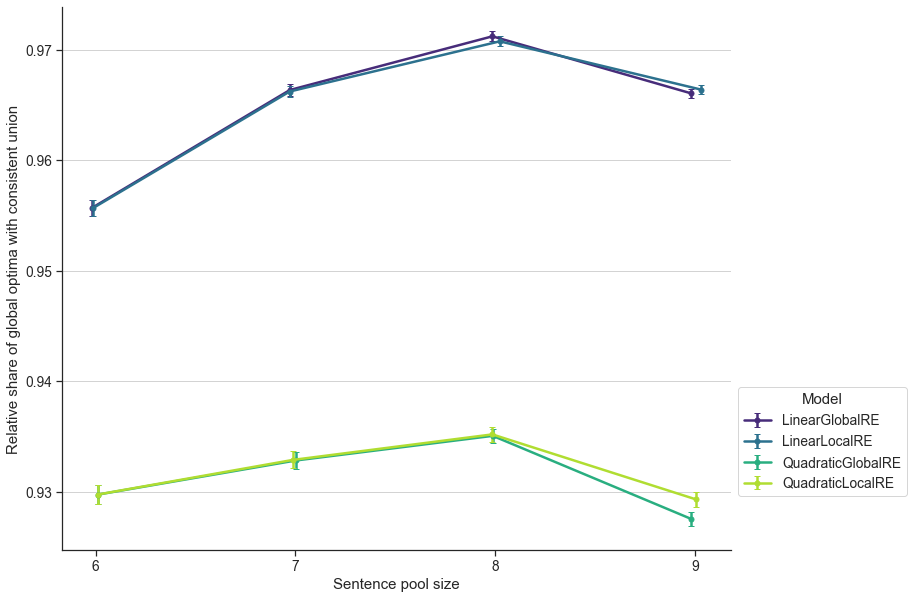

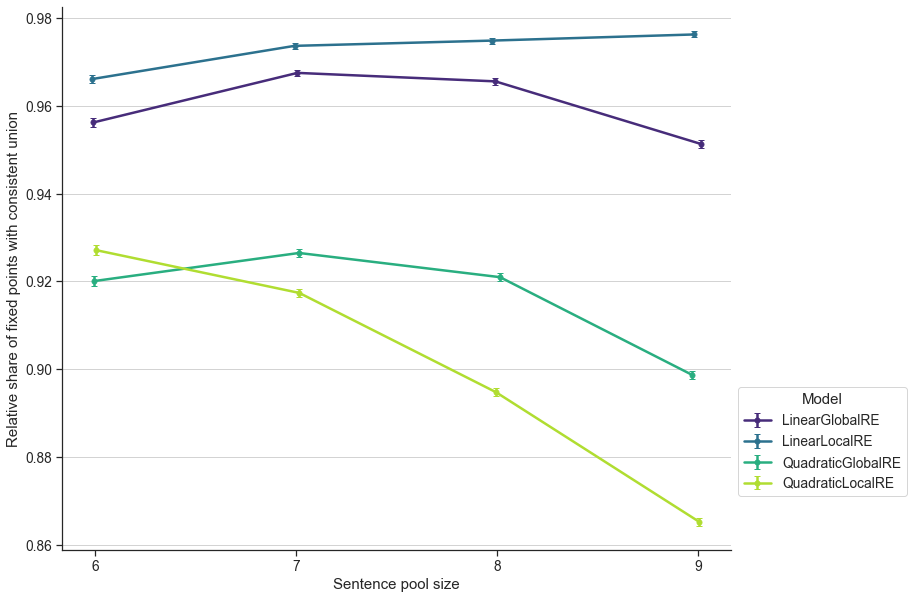

In [278]:
for df, endpoint_type in zip([restricted_go_data, restricted_fp_data], ["go", "fp"]):
    
    
    result_df = rel_share_of_property(df, 
                           "{}_union_consistent".format(endpoint_type), 
                            col_rename = None,
                            groupby_cols= grouping,
                            collapse_branches=False,
                            cols_group_branches = ['model_name','ds','init_coms', 'weight_account', 'weight_systematicity'],
                            explode_cols=None,
                            bootstrap=bootstrap, 
                            n_resamples=n_resamples)
    
    endpoint = "global optima" if endpoint_type == "go" else "fixed points"
    perspective = "pp" if analyse_branches else "rp"
    
    file_name = None
    if export_results:
        file_name = f"rel_consistent_union_{endpoint_type}_by_sp_{perspective}"
        
    # prepare plot styling
    ax=plt.gca()
    ax.set_prop_cycle(color=viridis)
    ax.xaxis.grid(False)
    ax.yaxis.grid(True)
    
    plot_multiple_error_bars(result_df.reset_index(), 
                             var_y = f"rel_{endpoint_type}_union_consistent", 
                             ylabel = f"Relative share of {endpoint} with consistent union",
                             xlabel = "Sentence pool size",
                             var_std=f"std_{endpoint_type}_union_consistent",
                             file_name=file_name,
                             output_dir = figures_output_dir)
    
    
    
    plt.show()

### Heatmaps

In [123]:
new_grouping = ["model_name", "weight_account", "weight_systematicity"]

In [124]:
# global optima

# restrict to global optima with consistent commitments (otherwise union is trivially inconsistent)
#wrestricted_go_data = exploded_go_data[exploded_go_data["go_coms_consistent"]]
#
#wrestricted_go_data = wrestricted_go_data.groupby(new_grouping)["go_union_consistent"].agg(["sum", "size"]).reset_index()
#
#
#wrestricted_go_data = wrestricted_go_data.rename(columns={'sum': "n_go_union_consistent",
#                                                  'size': 'n_global_optima'})
## relative share
#wrestricted_go_data["rel_go_union_consistent"] = wrestricted_go_data["n_go_union_consistent"]/wrestricted_go_data["n_global_optima"]
#
## sort by model name
#wrestricted_go_data['model_name'] = pd.Categorical(wrestricted_go_data['model_name'], ["QuadraticGlobalRE", "LinearGlobalRE", "QuadraticLocalRE", "LinearLocalRE"])
#wrestricted_go_data.sort_values("model_name", inplace=True)

#wrestricted_go_data

In [125]:
# fixed points

# restrict to fixed points with consistent commitments (otherwise union is trivially inconsistent)
#wrestricted_fp_data = exploded_fp_data[exploded_fp_data["fp_coms_consistent"]]
#
#wrestricted_fp_data = wrestricted_fp_data.groupby(new_grouping)["fp_union_consistent"].agg(["sum", "size"]).reset_index()
#
#
#wrestricted_fp_data = wrestricted_fp_data.rename(columns={'sum': "n_fp_union_consistent",
#                                                  'size': 'n_fixed_points'})
## relative share
#wrestricted_fp_data["rel_fp_union_consistent"] = wrestricted_fp_data["n_fp_union_consistent"]/wrestricted_fp_data["n_fixed_points"]
#
#
## sort by model name
#wrestricted_fp_data['model_name'] = pd.Categorical(wrestricted_fp_data['model_name'], ["QuadraticGlobalRE", "LinearGlobalRE", "QuadraticLocalRE", "LinearLocalRE"])
#wrestricted_fp_data.sort_values("model_name", inplace=True)


#wrestricted_fp_data

In [ ]:
sns.set(font_scale=1.0)

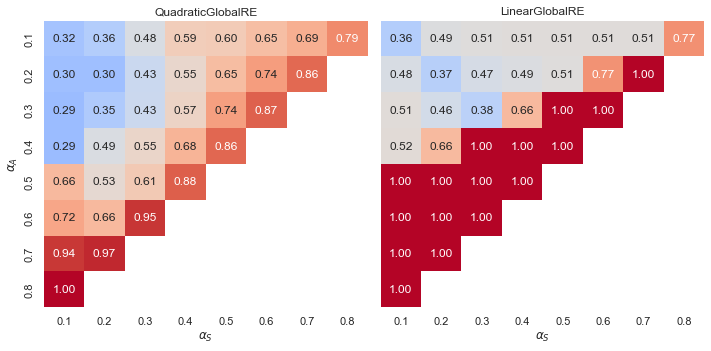

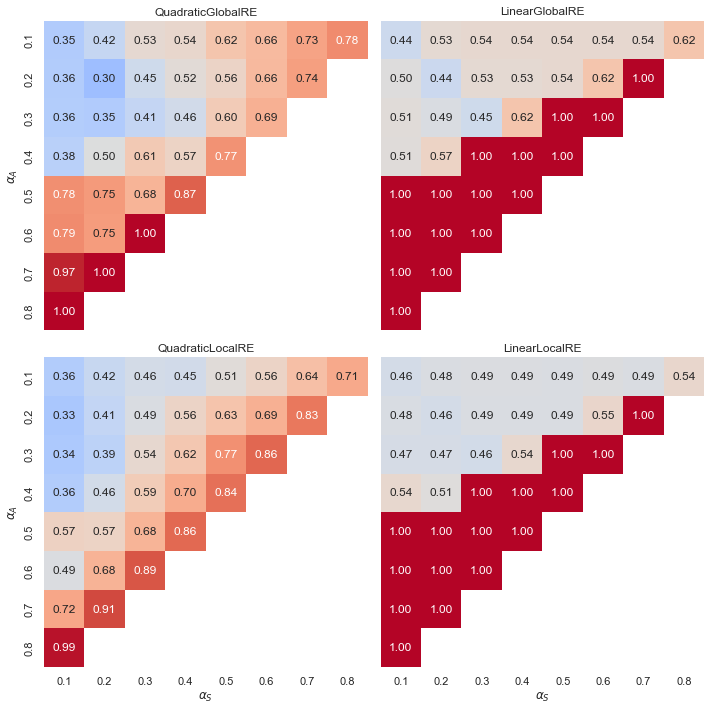

In [135]:
for df, endpoint_type in zip([exploded_go_data, exploded_fp_data], ["go", "fp"]):

    #endpoint = "global opima" if endpoint_type == "go" else "fixed points"
    
    #if (analyse_branches) & (endpoint_type=="fp"):
    #    endpoint += " (all branches)"
    
    # restrict global optima dataframe to two variants
    if endpoint_type=="go":
        rdf = df[df["model_name"].isin(go_models)]
    else:
        rdf=df
    
    heat_maps_by_weights(re_data = rdf, 
                     values = "{}_union_consistent".format(endpoint_type), 
                     #title = 'Relative share of consistent unions among {}'.format(endpoint),
                     annot_std = False,
                     annot_fmt="{:2.2f}\n", 
                     annot_std_fmt = r'$\pm${:2.2f}',
                     vmin=0,
                     vmax=1,
                     bootstrap=bootstrap,
                     n_resamples=n_resamples)
    
    
    branches = "pp" if analyse_branches else "rp" 
        
    if export_results:
        plt.savefig(path.join(figures_output_dir, 'hm_consistent_union_{}_{}.png'.format(endpoint_type, branches)), bbox_inches='tight')
        plt.savefig(path.join(figures_output_dir, 'hm_consistent_union_{}_{}.pdf'.format(endpoint_type, branches)), bbox_inches='tight')
        
    plt.show()